# Yoonhyuck Woo, Rishika Thorat / Purdue University_Computer and Information Technology
# Final Project Title: Movie Recommendation System
# Professor: Jin Wei-Kocsis, Ph.D.

- Reference: ***https://medium.com/@AMustafa4983/sentiment-analysis-on-imdb-movie-reviews-a-beginners-guide-d5136ec74e56***

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow
import keras
import re
import nltk
import string
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from nltk.stem.porter import *

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

# IMDB DATASET

In [ ]:
# Load Dataset
imdb_df = pd.read_csv('/content/drive/MyDrive/IMDB_Dataset.csv') # put your path here

In [ ]:
imdb_df['sentiment']=imdb_df['sentiment'].replace({'positive':1, 'negative':0})

In [ ]:
# check for bias
imdb_df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

# Function1: Removing Stopwords.

In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    filtered_sentence = ''

    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [ ]:
def normalize_text(text):
    text = text.lower()
    # get rid of urls
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # get rid of non words and extra spaces
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

In [ ]:
def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [ ]:
def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [ ]:
def clean_text(text):
    text = text.lower()
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

In [ ]:
with tf.device('/device:GPU:0'):

  for i in range (len(imdb_df["review"])):
    imdb_df["review"][i] = clean_text(imdb_df["review"][i])

<ipython-input-18-ecdc8ccc4d89>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_df["review"][i] = clean_text(imdb_df["review"][i])


In [ ]:
X = imdb_df["review"]
y = imdb_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   shuffle=True)

# Tokenization and Padding

In [ ]:
# important properties
vocab_size = 10000
max_length = 50

trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

In [ ]:
# Define tokenizer and fit on texts
tokenizer.fit_on_texts(X_train)

In [ ]:
# Let's Tokenize and pad texts
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)
X_test = pad_sequences(X_test, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)

In [ ]:
def build_model():
    model = tf.keras.Sequential()

    model.add(Embedding(vocab_size, 64, input_length=max_length))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))  # Add dropout regularization

    model.add(LSTM(32, return_sequences=True))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))  # Add dropout regularization

    model.add(LSTM(32))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))  # Add dropout regularization

    # model.add(Dense(2, activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


    return model

In [ ]:
import os
checkpoint_path = "/content/drive/MyDrive/sentiment_training/ckpt-{epoch:03d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
batch_size = 250
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0,
                                                 )


In [ ]:
with tf.device('/device:GPU:0'):

  model = build_model()
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Apply early stopping

  history = model.fit(X_train, y_train, epochs=15, batch_size=batch_size, validation_split=.1, callbacks=[cp_callback])

NameError: ignored

[0.8423406481742859, 0.7919999957084656]


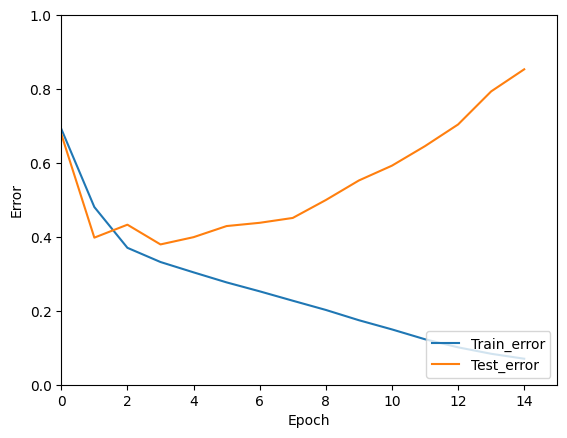

In [ ]:
# Visualize performance evaluation
plt.plot(history.history['loss'], label='Train_error')
plt.plot(history.history['val_loss'], label = 'Test_error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.xlim([0, len(history.history['loss'])])
plt.ylim([0, 1])
plt.legend(loc='lower right')

results = model.evaluate(X_test, y_test, verbose = 0, callbacks=[cp_callback])
print(results)
# print('Train Error:', round(results[0],7), '\t', 'Test Error:',  round(results[1], 7))

In [ ]:
# os.listdir(checkpoint_dir)

saved_model = "/content/drive/MyDrive/sentiment_training/ckpt-005.ckpt"
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# latest

In [ ]:
# Create a new model instance
new_model = build_model()

# Load the previously saved weights
new_model.load_weights(saved_model)

In [ ]:
def sentiment_predict(new_sentence, model, saved_model):
  # new_sentence = re.sub(r'[^a-zA-Z ]', '', new_sentence)
  # new_sentence = okt.morphs(new_sentence, stem=True) # Tokenizer
  # new_sentence = [word for word in new_sentence if not word in stopwords]

  # Create a new model instance
  sentiment_analysis_model = model

  # Load the previously saved weights
  sentiment_analysis_model.load_weights(saved_model)

  new_sentence = clean_text(new_sentence)
  encoded = tokenizer.texts_to_sequences([new_sentence]) # Encoding

  encoded = np.array(encoded)
  pad_new = pad_sequences(encoded, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)
  score = float(sentiment_analysis_model.predict(pad_new)) # Prediction
  if(score > 0.5):
    print("{:.2f}% positive review.\n".format(score * 100))
  else:
    print("{:.2f}% negative review.\n".format((1 - score) * 100))

In [ ]:
new_model = build_model()
sentiment_predict('''If you LOVE this film, please read the rest of my post. I personally think that this documentary is great!
As usual, David Attenborough narrated this series. If you enjoyed this series, you will definitely love his other ones.
If you are a bird lover, I would recommend watching the film " The Life of Birds." It's a 1998 documentary about birds (duh)! ''', new_model, saved_model)

1/1 [==============================] - 2s 2s/step
97.55% positive review.



In [ ]:
sentiment_predict('''Surrounded by the warmth of sunshine and the laughter of loved ones''', new_model, saved_model)

1/1 [==============================] - 0s 241ms/step
58.95% positive review.



In [ ]:
Surrounded by the warmth of sunshine and the laughter of loved ones, every moment becomes a cherished memory.